In [1]:
# Import some libraries
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt, numpy as np, os
from fredapi import Fred
from bls import get_series


In [2]:
# load APIs
from dotenv import load_dotenv
load_dotenv()

# Configure FRED and BLS API keys
API_KEY = os.getenv('FRED_API_KEY')
# os.environ['BLS_API_KEY'] = os.getenv('BLS_API_KEY')

# Initialize FRED API
fred = Fred(api_key=API_KEY)

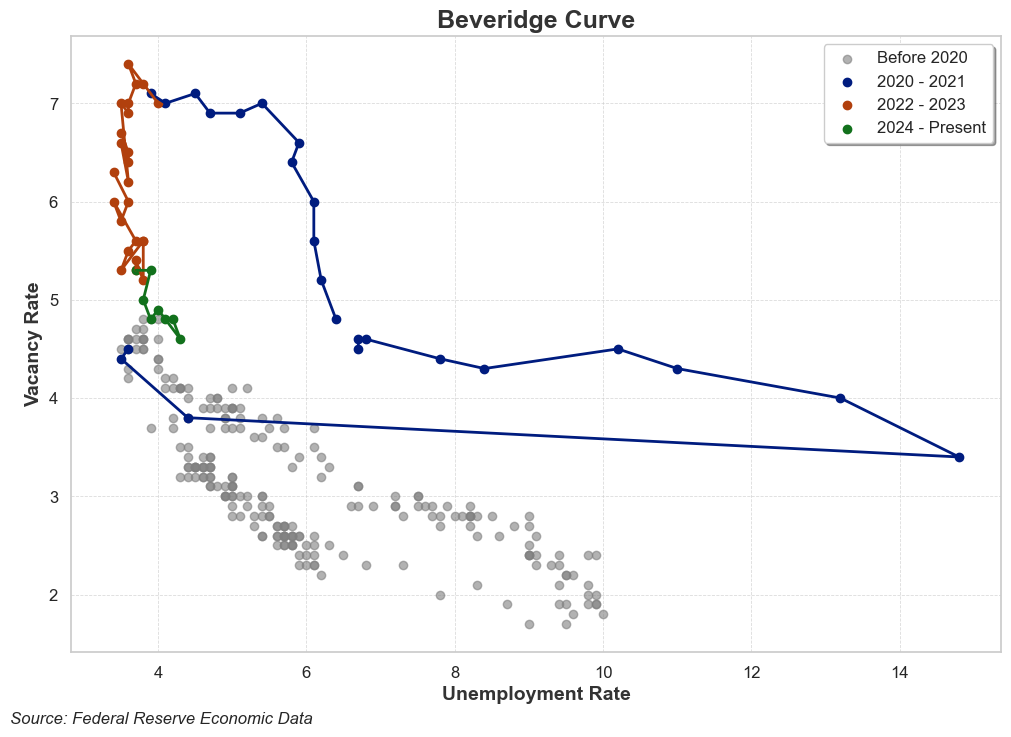

In [3]:
# Add Scatter plot for Beveridge Curve
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot scatter plot using FRED or BLS data
def plot_scatter(series_dict, title, legend_text_generator, from_date='2000-01-01', x_label='Unemployment Rate', 
                 y_label='Vacancy Rate', year_cutoff=2022, legend_loc='upper right', custom_text='Source: Federal Reserve Economic Data',
                 add_line=False):
    # Initialize an empty DataFrame for merging
    merged_df = pd.DataFrame()

    # Fetch each series (vacancy and unemployment) based on its source (FRED or BLS)
    for idx, (series_id, source) in enumerate(series_dict.items()):
        if source == 'FRED':
            try:
                data = fred.get_series(series_id)
            except Exception as e:
                raise ValueError(f"Error fetching FRED series {series_id}: {e}")
        elif source == 'BLS':
            try:
                unformatted_data = get_series(series_id)  # Assuming get_series fetches BLS data

                # Convert the BLS data into a format similar to FRED (pandas Series with Date as index)
                x = unformatted_data.index.to_timestamp()
                y = unformatted_data.values
                data = pd.Series(y, index=x)
            except Exception as e:
                raise ValueError(f"Error fetching BLS series {series_id}: {e}")
        else:
            raise ValueError(f"Invalid source '{source}' for series {series_id}. Use 'FRED' or 'BLS'.")

        # Create DataFrame from the fetched data
        df = pd.DataFrame(data, columns=[f"Value_{idx}"])
        df['Date'] = df.index
        df = df[df['Date'] >= from_date]  # Filter from the specified date onwards

        # Merge with the main DataFrame on 'Date'
        if merged_df.empty:
            merged_df = df
        else:
            merged_df = pd.merge(merged_df, df, on="Date", how="inner")

    # Split the data by year
    merged_df['Year'] = pd.DatetimeIndex(merged_df['Date']).year

    # Set up the style using seaborn
    sns.set(style="whitegrid", palette="dark")

    # Create a figure and axis
    plt.figure(figsize=(12, 8))

    # Plot before and after the cutoff year using different colors
    before_cutoff = merged_df[merged_df['Year'] < year_cutoff]
    after_cutoff = merged_df[merged_df['Year'] >= year_cutoff]

    # Plot the points before the cutoff
    plt.scatter(before_cutoff[f'Value_0'], before_cutoff[f'Value_1'], label=f'Before {year_cutoff}', color='gray', alpha=0.6)

    # Plot the points after the cutoff with a color gradient
    unique_years = after_cutoff['Year'].unique()
    colors = sns.color_palette("dark", len(unique_years))

    for idx in range(0, len(unique_years), 2):
        year = int(unique_years[idx])
        year_data = after_cutoff[after_cutoff['Year'] == year] 
        plt.scatter(year_data[f'Value_0'], year_data[f'Value_1'], label=f'{year} - {year + 1 if year != 2024 else "Present"}', color=colors[int(idx / 2)])
        if add_line:
            plt.plot(year_data[f'Value_0'], year_data[f'Value_1'], 
                color=colors[int(idx / 2)], 
                linewidth=2)  # You can adjust the linewidth as needed
        
        year_data = after_cutoff[after_cutoff['Year'] == year + 1] 
        plt.scatter(year_data[f'Value_0'], year_data[f'Value_1'], color=colors[int(idx / 2)])

        if add_line:
            plt.plot(year_data[f'Value_0'], year_data[f'Value_1'], 
                color=colors[int(idx / 2)], 
                linewidth=2)  # You can adjust the linewidth as needed
            
    # Add labels and title
    plt.title(title, fontsize=18, weight='bold', color='#333333')
    plt.xlabel(x_label, fontsize=14, weight='bold', color='#333333')
    plt.ylabel(y_label, fontsize=14, weight='bold', color='#333333')

    # Rotate x-axis labels for better readability
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Add a grid
    plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)

    # Add a legend
    plt.legend(loc=legend_loc, frameon=True, fontsize=12, fancybox=True, shadow=True)

    # Add a footer with source information
    plt.figtext(0.2, 0.02, custom_text, ha="center", fontsize=12, style='italic')

    # Display the plot
    plt.show()

# Example to test the function with mock data
series_dict = {
    'UNRATE': 'FRED',   # Unemployment rate data
    'JTSJOR': 'FRED',  # Vacancy rate data
}

legend_text_generator = ['Vacancy Rate (JTSJOR)', 'Unemployment Rate (UNRATE)']

plot_scatter(series_dict, "Beveridge Curve", legend_text_generator, year_cutoff=2020, add_line=True)


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Plot line FRED or BLS data
def plot_series(series_dict, title, legend_text_generator, from_date='2000-01-01', x_label='Date', y_label='Series Value', 
                change_in=False, plot_type=sns.lineplot, legend_loc='upper right', percent_change=False, year_over_year=False, periods_in_year=None,
                custom_text='Source: Federal Reserve Economic Data'):
    """
    Fetches and plots multiple FRED or BLS series on the same graph.
    
    Parameters:
    - series_dict: Dictionary where keys are series IDs and values are the source ('FRED' or 'BLS')
    - title: The title of the plot
    - legend_text_generator: A list that provides custom text for the legend for each series
    - from_date: The starting date for the series (default is '2000-01-01')
    - x_label: The label for the x-axis (default is 'Date')
    - y_label: The label for the y-axis (default is 'Series Value')
    - change_in: Whether to calculate the difference or percentage change (default False)
    - percent_change: Whether to calculate percentage change instead of raw differences (default False)
    - year_over_year: Whether to calculate year-over-year percentage change (default False)
    """
    # Initialize an empty DataFrame for merging
    merged_df = pd.DataFrame()

    # Fetch each series based on its source (FRED or BLS) and merge into the DataFrame
    for idx, (series_id, source) in enumerate(series_dict.items()):
        if source == 'FRED':
            try:
                data = fred.get_series(series_id)
            except Exception as e:
                raise ValueError(f"Error fetching FRED series {series_id}: {e}")
        elif source == 'BLS':
            try:
                unformatted_data = get_series(series_id)  # Assuming get_series fetches BLS data

                # Convert the BLS data into a format similar to FRED (pandas Series with Date as index)
                x = unformatted_data.index.to_timestamp()
                y = unformatted_data.values
                data = pd.Series(y, index=x)
            except Exception as e:
                raise ValueError(f"Error fetching BLS series {series_id}: {e}")
        elif source == 'FILE':
            pass
        else:
            raise ValueError(f"Invalid source '{source}' for series {series_id}. Use 'FRED' or 'BLS'.")

        # Create DataFrame from the fetched data
        
        if source == 'FILE':
            df = pd.read_csv(series_id, index_col=0, parse_dates=True)
        else:
            df = pd.DataFrame(data, columns=[f"Value_{idx}"])
        df['Date'] = df.index
        df = df[df['Date'] >= from_date]  # Filter from the specified date onwards

        # Merge with the main DataFrame on 'Date'
        if merged_df.empty:
            merged_df = df
        else:
            merged_df = pd.merge(merged_df, df, on="Date", how="inner")

    if periods_in_year is None:
        # If frequency is not inferred, use median difference
        median_diff = merged_df['Date'].diff().median()
        periods_in_year = pd.Timedelta('365 days') / median_diff

    # If change_in is True, calculate either diff or percentage change
    if change_in:
        if percent_change:
            for idx in range(len(series_dict)):
                merged_df[f'Value_{idx}'] = merged_df[f'Value_{idx}'].pct_change() * 100
        else:
            for idx in range(len(series_dict)):
                merged_df[f'Value_{idx}'] = merged_df[f'Value_{idx}'].diff()

    # If year_over_year is True, calculate YoY percentage change
    if year_over_year:
        for idx in range(len(series_dict)):
            merged_df[f'Value_{idx}'] = merged_df[f'Value_{idx}'].pct_change(int(periods_in_year)) * 100

    # Set up the style using seaborn
    sns.set(style="whitegrid", palette="dark")

    # Create a figure and axis with a larger size for better aesthetics
    plt.figure(figsize=(12, 8))

    # Plot each series
    for idx in range(len(df.columns) - 1):
        plot_type(x='Date', y=f'Value_{idx}', data=merged_df, 
                     label=legend_text_generator[idx], linewidth=2, markers=True, marker='o')

    # Enhance the title and labels
    plt.title(title, fontsize=18, weight='bold', color='#333333')
    plt.xlabel(x_label, fontsize=14, weight='bold', color='#333333')
    plt.ylabel(y_label, fontsize=14, weight='bold', color='#333333')

    # Rotate the x-axis labels for better readability and adjust their size
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(fontsize=12)

    # Add a grid with more customization
    plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)

    # Show the legend with a custom location and background
    plt.legend(loc=legend_loc, frameon=True, fontsize=12, fancybox=True, shadow=True)

    # Check which source it has
    if 'FRED' in series_dict.values() and 'BLS' in series_dict.values():
        # Add a footer with the source of the data
        plt.figtext(0.27, 0, 'Source: Federal Reserve Economic Data and U.S. Bureau of Labor Statistics', ha="center", fontsize=12, style='italic')
    elif 'FRED' in series_dict.values():
        # Add a footer with the source of the data
        plt.figtext(0.17, 0, 'Source: Federal Reserve Economic Data', ha="center", fontsize=12, style='italic')
    elif 'BLS' in series_dict.values():
        # Add a footer with the source of the data
        plt.figtext(0.17, 0, 'Source: U.S. Bureau of Labor Statistics', ha="center", fontsize=12, style='italic')
    else:
        # Add a footer with the source of the data
        plt.figtext(0.17, 0, custom_text, ha="center", fontsize=12, style='italic')
        
    # Tighten layout to make the plot look cleaner
    plt.tight_layout()

    # Display the plot
    plt.show()


In [5]:
# line graph that looks like a bar graph
from matplotlib.lines import Line2D


def plot_series_with_vlines(series_dict, title, legend_text_generator, from_date='2000-01-01', x_label='Date', y_label='Series Value', change_in=False, legend_loc='upper right', percent_change=False, line_width=10, year_over_year=False, periods_in_year=None):
    """
    Fetches and plots multiple FRED or BLS series on the same graph with vertical lines from each data point to the x-axis.
    
    Parameters:
    - series_dict: Dictionary where keys are series IDs and values are the source ('FRED' or 'BLS')
    - title: The title of the plot
    - legend_text_generator: A list that provides custom text for the legend for each series
    - from_date: The starting date for the series (default is '2000-01-01')
    - x_label: The label for the x-axis (default is 'Date')
    - y_label: The label for the y-axis (default is 'Series Value')
    """
    # Initialize an empty DataFrame for merging
    merged_df = pd.DataFrame()

    # Fetch each series based on its source (FRED or BLS) and merge into the DataFrame
    for idx, (series_id, source) in enumerate(series_dict.items()):
        if source == 'FRED':
            try:
                data = fred.get_series(series_id)
            except Exception as e:
                raise ValueError(f"Error fetching FRED series {series_id}: {e}")
        elif source == 'BLS':
            try:
                unformatted_data = get_series(series_id)  # Assuming get_series fetches BLS data

                # Convert the BLS data into a format similar to FRED (pandas Series with Date as index)
                x = unformatted_data.index.to_timestamp()
                y = unformatted_data.values
                data = pd.Series(y, index=x)
            except Exception as e:
                raise ValueError(f"Error fetching BLS series {series_id}: {e}")
        else:
            raise ValueError(f"Invalid source '{source}' for series {series_id}. Use 'FRED' or 'BLS'.")

        # Create DataFrame from the fetched data
        df = pd.DataFrame(data, columns=[f"Value_{idx}"])
        df['Date'] = df.index
        df = df[df['Date'] >= from_date]  # Filter from the specified date onwards

        # Merge with the main DataFrame on 'Date'
        if merged_df.empty:
            merged_df = df
        else:
            merged_df = pd.merge(merged_df, df, on="Date", how="inner")

    # use median difference to find periods in a year
    if periods_in_year is None:
        median_diff = merged_df['Date'].diff().median()
        periods_in_year = pd.Timedelta('365 days') / median_diff

    print("Periods in year", periods_in_year)

    # If change_in is True, calculate either diff or percentage change
    if change_in:
        if percent_change:
            for idx in range(len(series_dict)):
                merged_df[f'Value_{idx}'] = merged_df[f'Value_{idx}'].pct_change() * 100
        else:
            for idx in range(len(series_dict)):
                merged_df[f'Value_{idx}'] = merged_df[f'Value_{idx}'].diff()

    # If year_over_year is True, calculate YoY percentage change
    if year_over_year:
        for idx in range(len(series_dict)):
            merged_df[f'Value_{idx}'] = merged_df[f'Value_{idx}'].pct_change(int(periods_in_year)) * 100

    # Set up the style using seaborn
    sns.set(style="whitegrid", palette="dark")

    # Create a figure and axis with a larger size for better aesthetics
    plt.figure(figsize=(12, 8))

    custom_legend = []

    # Plot each series
    for idx in range(len(series_dict)):
        # Plot the main line for each series
        # plot_type(x='Date', y=f'Value_{idx}', data=merged_df, label=legend_text_generator[idx], linewidth=2)
        
        # Add vertical lines from each data point to the x-axis (y=0)
        plt.vlines(merged_df['Date'], ymin=0, ymax=merged_df[f'Value_{idx}'], color='blue', alpha=0.6, linewidth=line_width)
        custom_legend.append(Line2D([0], [0], color='blue', lw=line_width, label=legend_text_generator[idx]))

    # Enhance the title and labels
    plt.title(title, fontsize=18, weight='bold', color='#333333')
    plt.xlabel(x_label, fontsize=14, weight='bold', color='#333333')
    plt.ylabel(y_label, fontsize=14, weight='bold', color='#333333')

    # Rotate the x-axis labels for better readability and adjust their size
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(fontsize=12)

    # Add a grid with more customization
    plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)

    # Show the legend with a custom location and background
    custom_legend = [Line2D([0], [0], color='blue', lw=1, label=legend_text_generator[0])]

    # Extend the existing legend
    plt.legend(handles=custom_legend, loc=legend_loc, fontsize=12, fancybox=True, shadow=True)

    # Check which source it has
    if 'FRED' in series_dict.values() and 'BLS' in series_dict.values():
        # Add a footer with the source of the data
        plt.figtext(0.27, 0, 'Source: Federal Reserve Economic Data and U.S. Bureau of Labor Statistics', ha="center", fontsize=12, style='italic')
    elif 'FRED' in series_dict.values():
        # Add a footer with the source of the data
        plt.figtext(0.17, 0, 'Source: Federal Reserve Economic Data', ha="center", fontsize=12, style='italic')
    else:
        # Add a footer with the source of the data
        plt.figtext(0.17, 0, 'Source: U.S. Bureau of Labor Statistics', ha="center", fontsize=12, style='italic')
    
    # Tighten layout to make the plot look cleaner
    plt.tight_layout()

    # Display the plot
    plt.show()


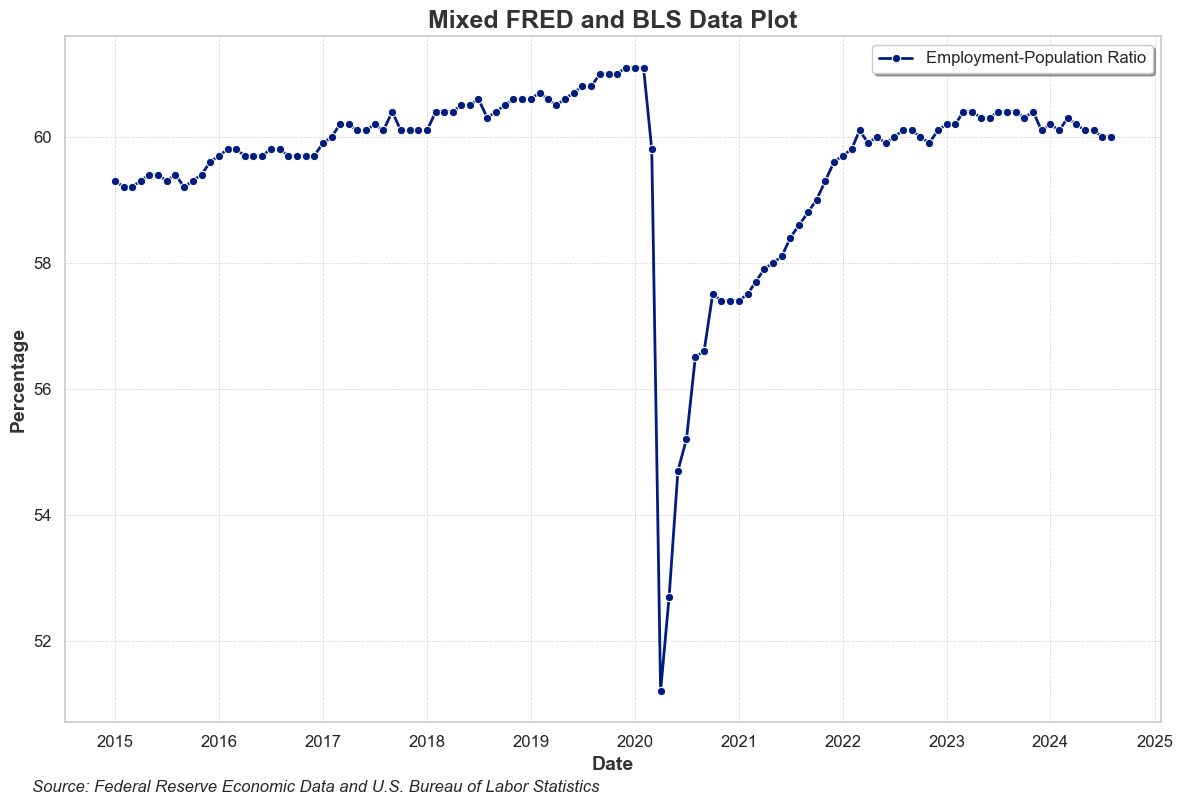

In [6]:
# test graph
# Define the series IDs and their sources
# Define the series IDs and their sources
series_dict = {
    'EMRATIO': 'FRED',       # Civilian Employment-Population Ratio (FRED, Percentage)
    'LNS14000000': 'BLS'     # Unemployment Rate (BLS, Percentage)
}

legend = ['Employment-Population Ratio', 'Unemployment Rate']


plot_series(series_dict, 'Mixed FRED and BLS Data Plot', legend, from_date='2015-01-01', y_label='Percentage')

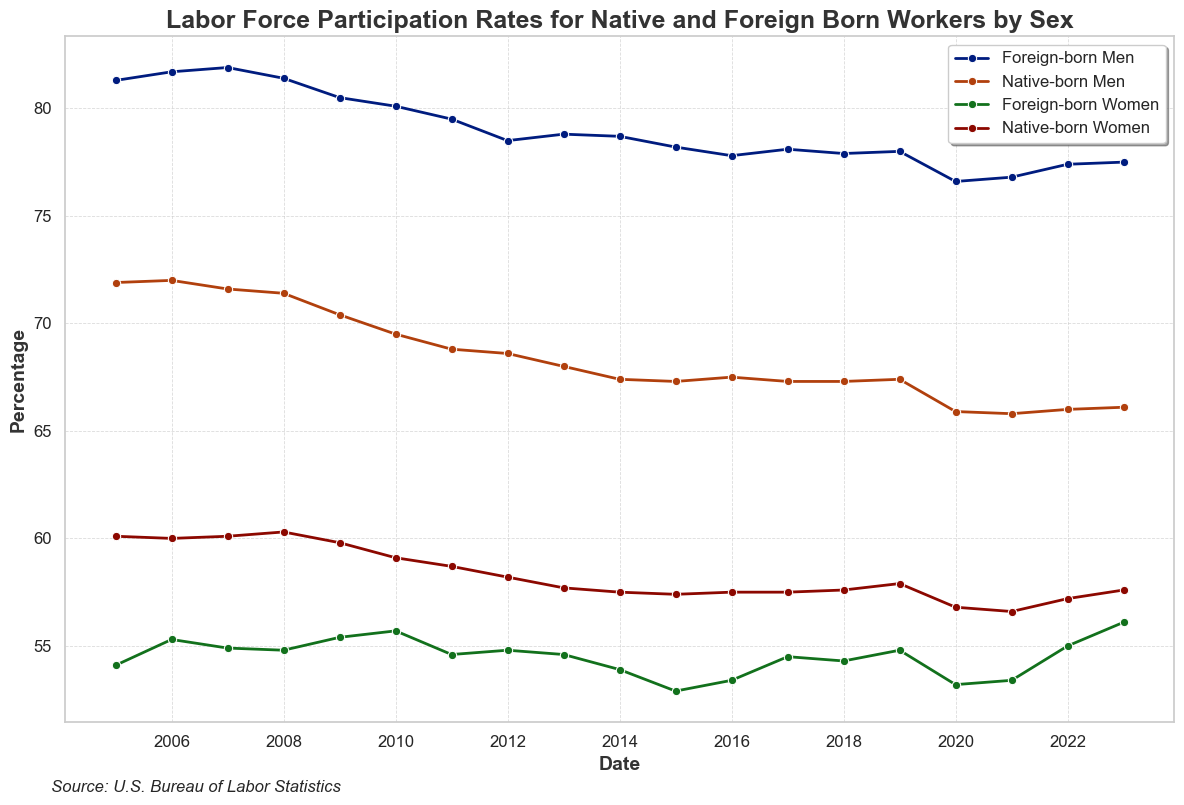

In [30]:
# Unemployment Rate (2020 to Present)
# Define the series IDs you want to plot
series_ids = {
    'data/foreign-native.csv': 'FILE',
}

legend = [
    "Foreign-born Men",
    "Native-born Men",
    "Foreign-born Women",
    "Native-born Women"
]

plot_series(series_ids, 
                 title="Labor Force Participation Rates for Native and Foreign Born Workers by Sex", 
                 legend_text_generator=legend,
                 y_label='Percentage',
                 from_date='2005-01-01',
                 custom_text='Source: U.S. Bureau of Labor Statistics')


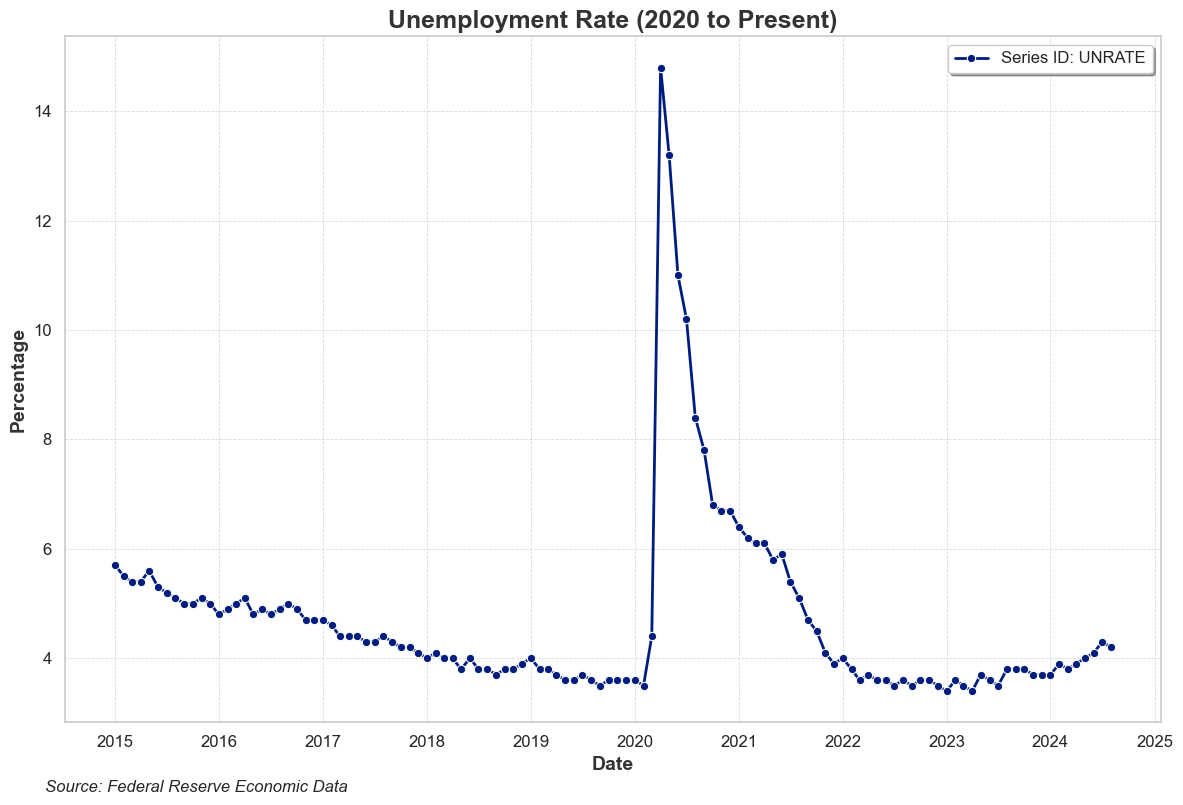

In [8]:
# Unemployment Rate (2020 to Present)
# Define the series IDs you want to plot
series_ids = {
    'UNRATE': 'FRED',
}

legend = [
    "Series ID: UNRATE",
]


plot_series(series_ids, 
                 title="Unemployment Rate (2020 to Present)", 
                 legend_text_generator=legend,
                 y_label='Percentage',
                 from_date='2015-01-01')


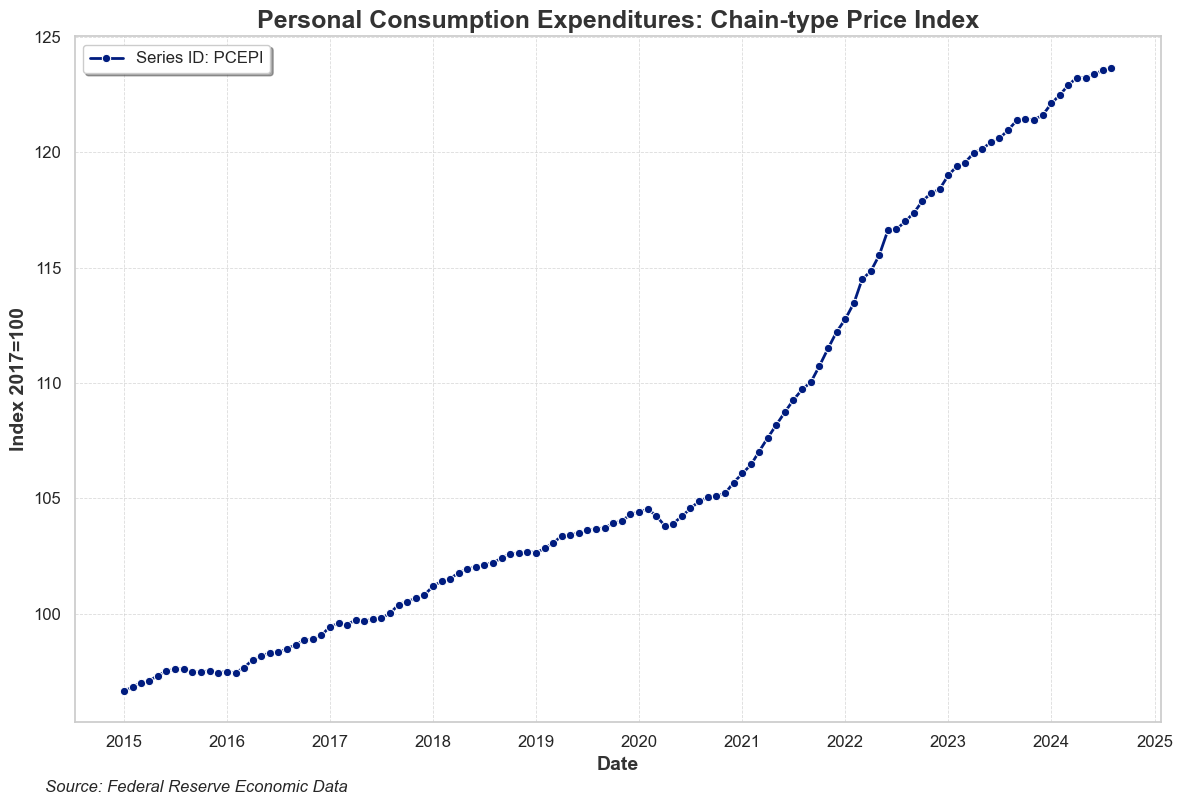

In [9]:
# PCE 
# Define the series IDs you want to plot
series_ids = {
    'PCEPI': 'FRED',
}

legend = [
    "Series ID: PCEPI",
]


plot_series(series_ids, 
                 title="Personal Consumption Expenditures: Chain-type Price Index", 
                 legend_text_generator=legend,
                 y_label='Index 2017=100',
                 from_date='2015-01-01',
                 legend_loc='upper left')


Periods in year 12


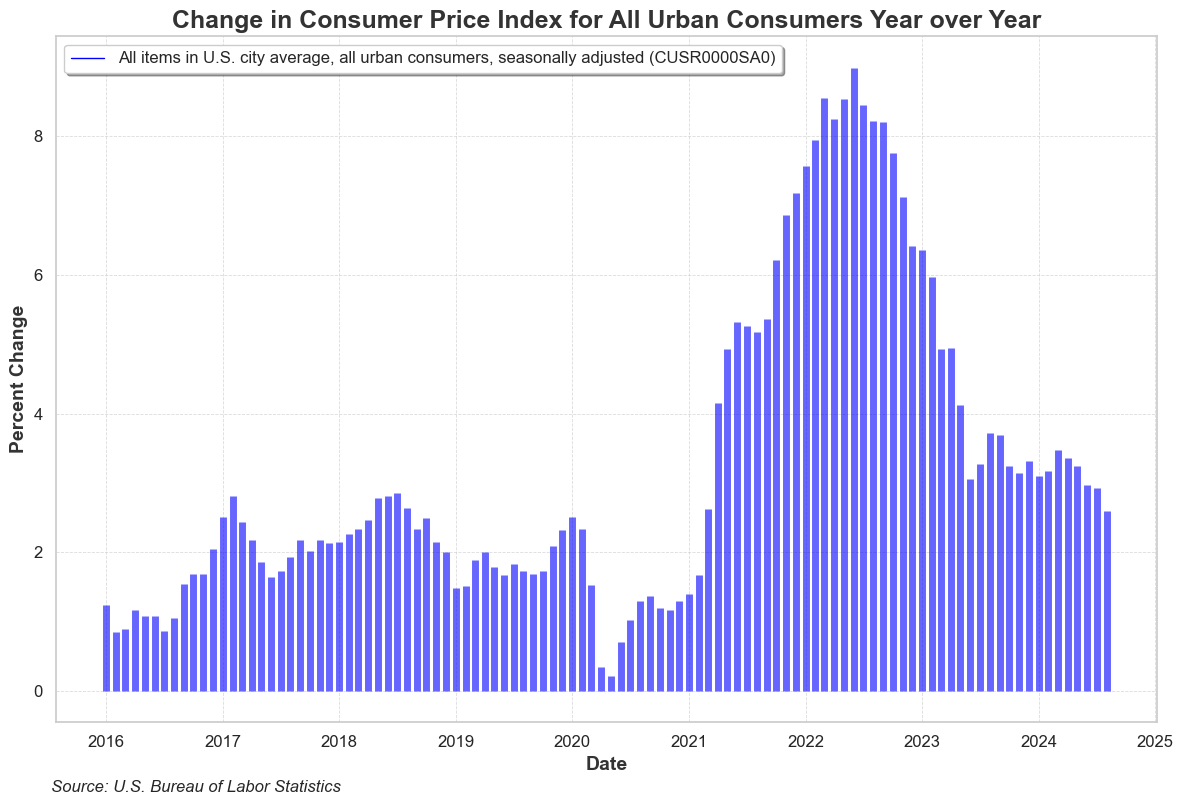

In [10]:
# CPI for All Urban Consumers

# Define the series IDs you want to plot
series_ids = {
    'CUSR0000SA0': 'BLS',
}

legend = [
    "All items in U.S. city average, all urban consumers, seasonally adjusted (CUSR0000SA0)",
]


plot_series_with_vlines(series_ids, 
                 title="Change in Consumer Price Index for All Urban Consumers Year over Year", 
                 legend_text_generator=legend,
                 y_label='Percent Change',
                 from_date='2015-01-01',
                 year_over_year=True,
                 line_width=5,
                 legend_loc='upper left',
                 periods_in_year=12)


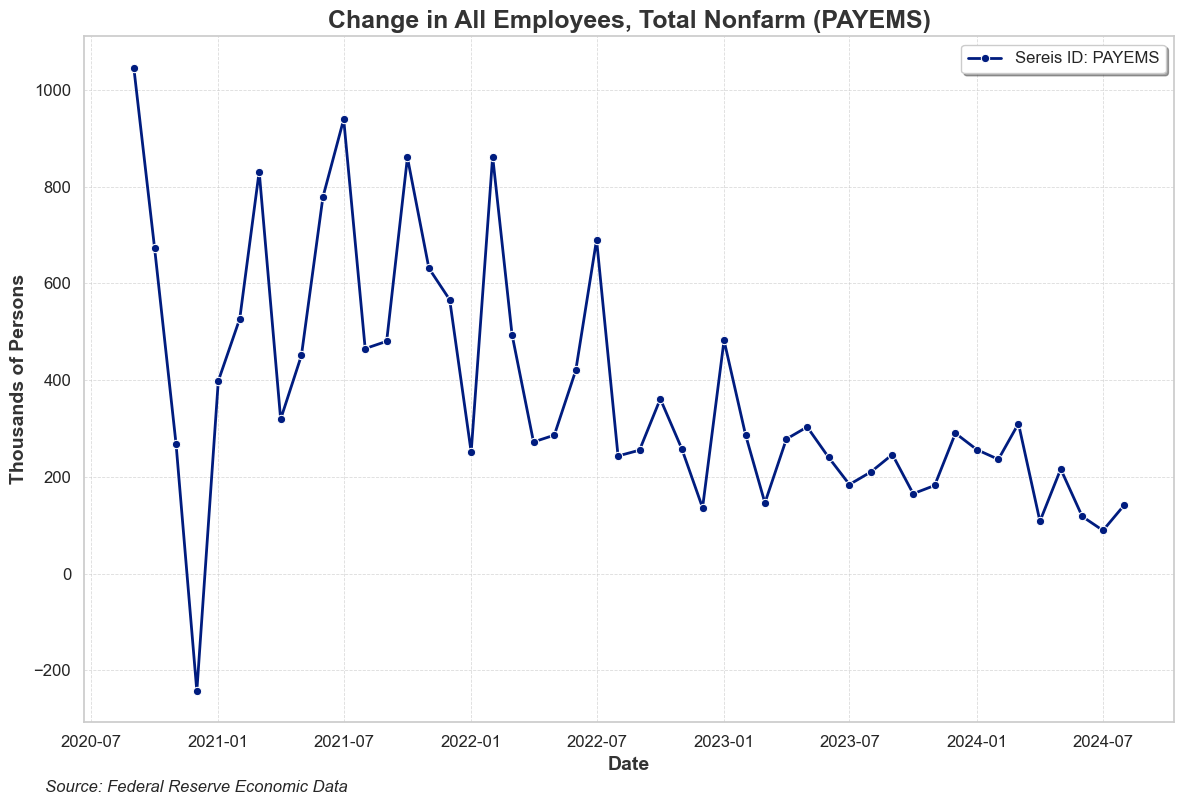

In [11]:
# Change in All Employees, Total Nonfarm (PAYEMS)

# Define the series IDs you want to plot
series_ids = {'PAYEMS': 'FRED',}

legend = ["Sereis ID: PAYEMS",]


plot_series(series_ids, 
                 title="Change in All Employees, Total Nonfarm (PAYEMS)", 
                 y_label='Thousands of Persons',
                 legend_text_generator=legend,
                 from_date='2020-08-01',
                 change_in=True)


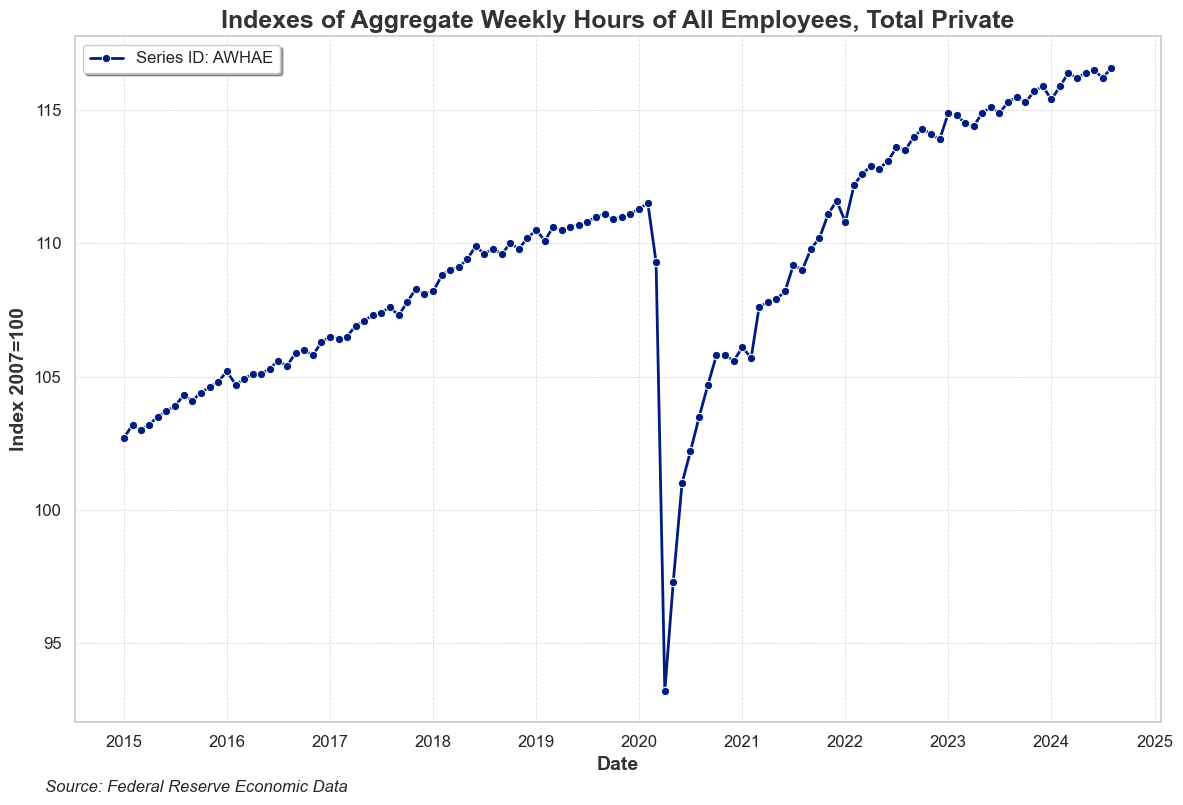

In [12]:
# Indexes of Aggregate Weekly Hours of All Employees, Total Private (AWHAE)

# Define the series IDs you want to plot
series_ids = {'AWHAE': 'FRED',}

legend = ["Series ID: AWHAE",]


plot_series(series_ids, 
                 title="Indexes of Aggregate Weekly Hours of All Employees, Total Private", 
                 y_label='Index 2007=100',
                 legend_text_generator=legend,
                 from_date='2015-01-01',
                 legend_loc='upper left')


Periods in year 12


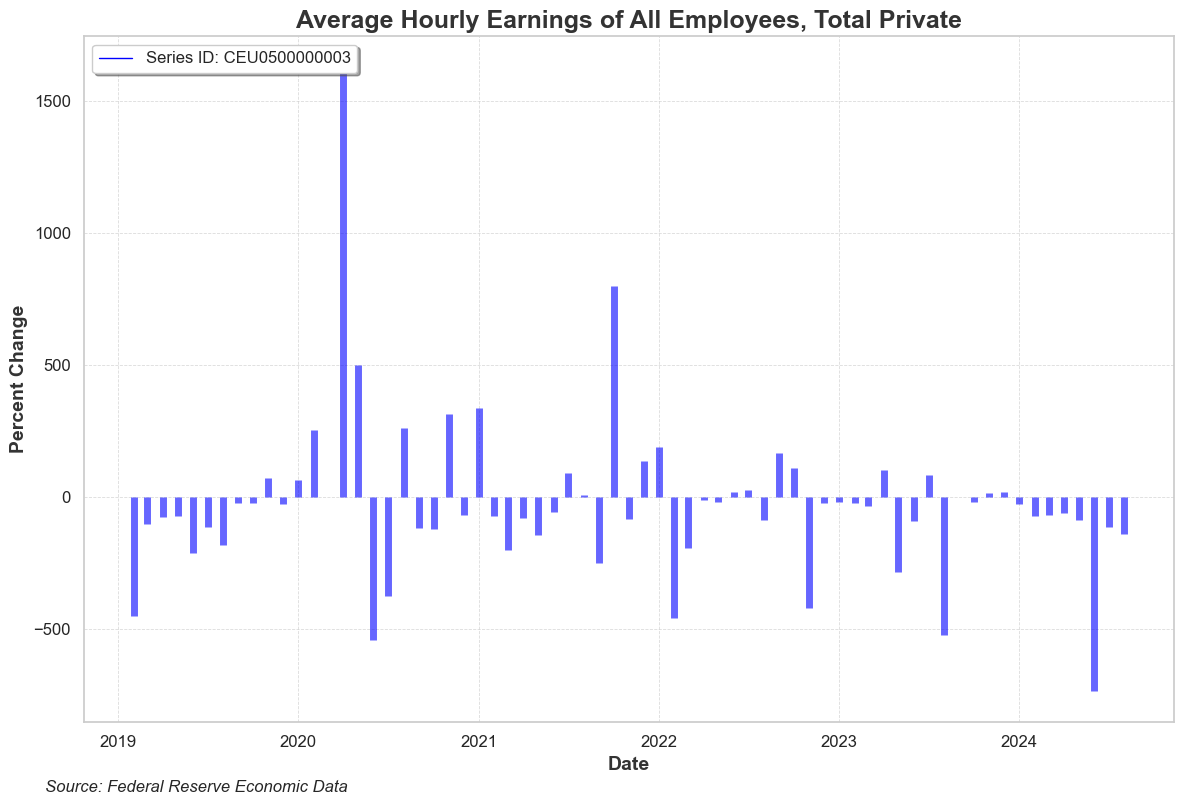

In [13]:
# Average Hourly Earnings of All Employees, Total Private (CEU0500000003)

# Define the series IDs you want to plot
series_ids = {'CEU0500000003': 'FRED',}

legend = ["Series ID: CEU0500000003",]


plot_series_with_vlines(series_ids, 
                 title="Average Hourly Earnings of All Employees, Total Private", 
                 y_label='Percent Change',
                 legend_text_generator=legend,
                 from_date='2018-01-01',
                 legend_loc='upper left',
                 change_in=True,
                 year_over_year=True,
                 periods_in_year=12,
                 line_width=5
                 )


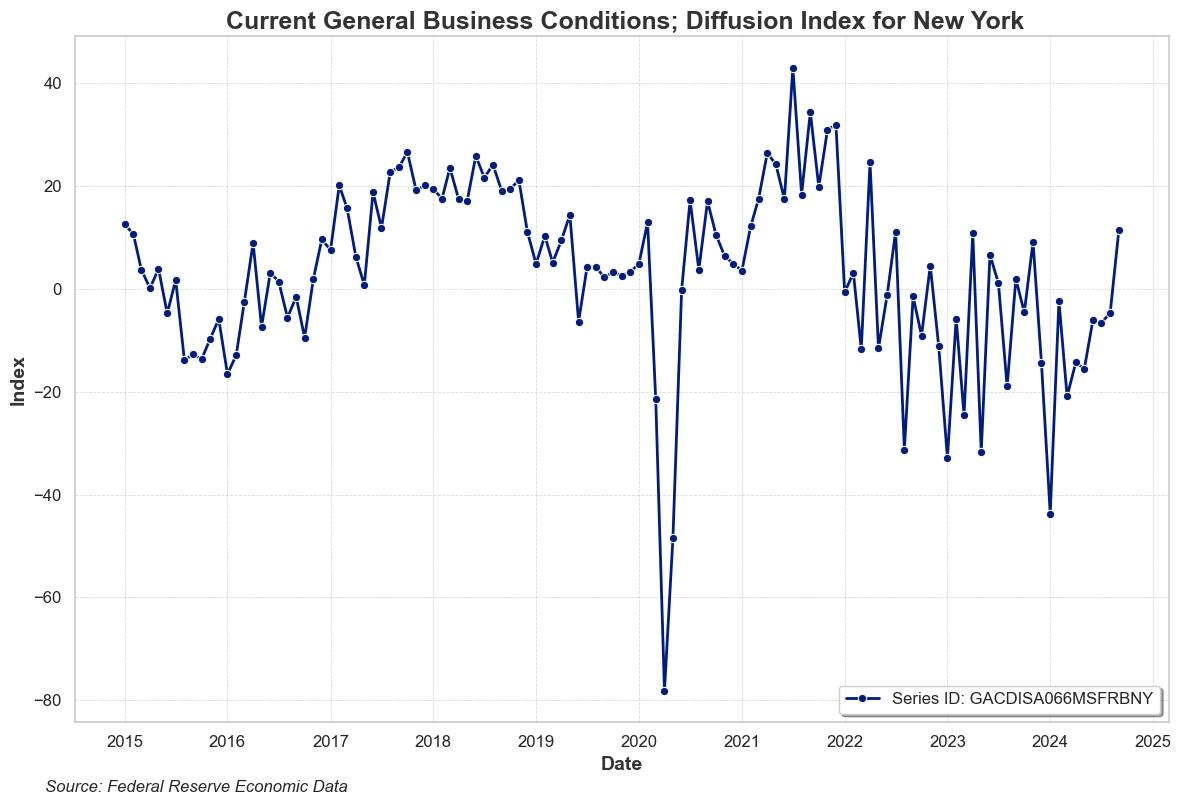

In [14]:
# Current General Business Conditions; Diffusion Index for New York (GACDISA066MSFRBNY)
# Define the series IDs you want to plot
series_ids = {'GACDISA066MSFRBNY': 'FRED',}

legend = ["Series ID: GACDISA066MSFRBNY",]


plot_series(series_ids, 
                 title=" Current General Business Conditions; Diffusion Index for New York", 
                 y_label='Index',
                 legend_text_generator=legend,
                 from_date='2015-01-01',
                 legend_loc='lower right',)


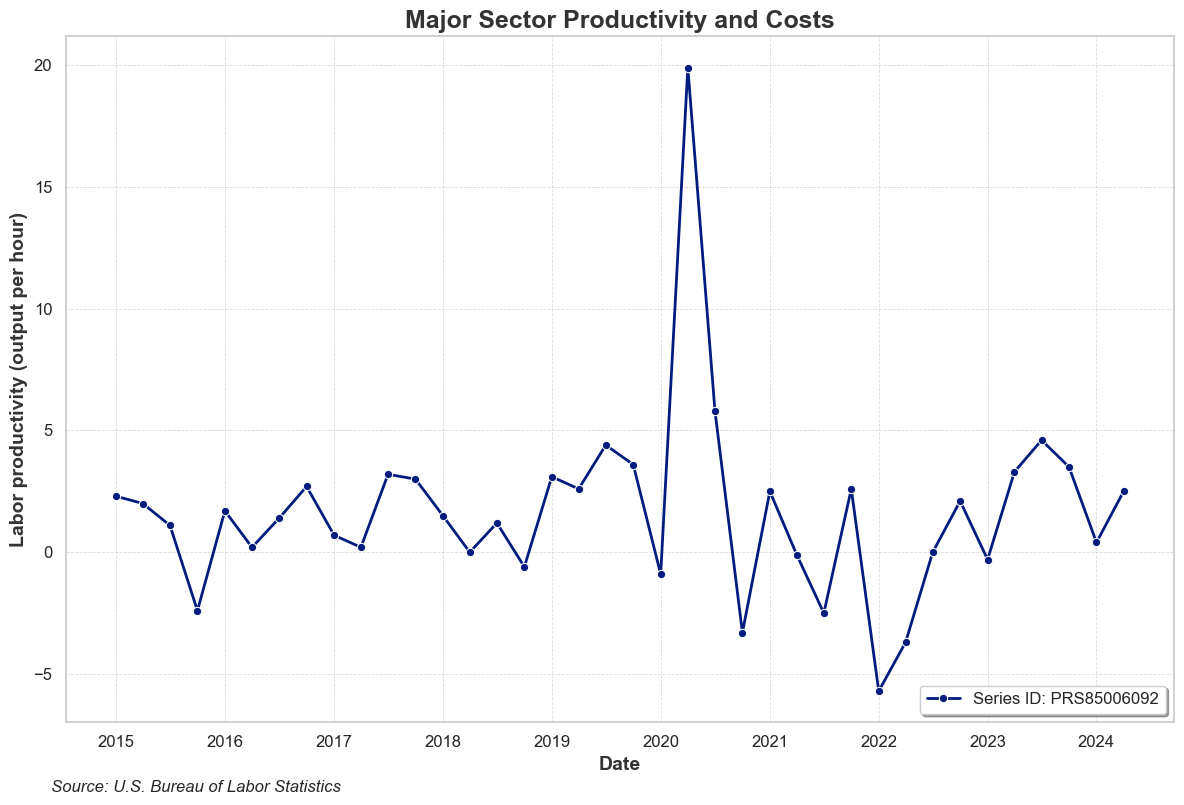

In [15]:
# Major Sector Productivity and Costs (PRS85006092)

# Define the series IDs you want to plot
series_ids = {'PRS85006092': 'BLS',}

legend = ["Series ID: PRS85006092",]


plot_series(series_ids, 
                 title="Major Sector Productivity and Costs", 
                 y_label='Labor productivity (output per hour)',
                 legend_text_generator=legend,
                 from_date='2015-01-01',
                 legend_loc='lower right',)


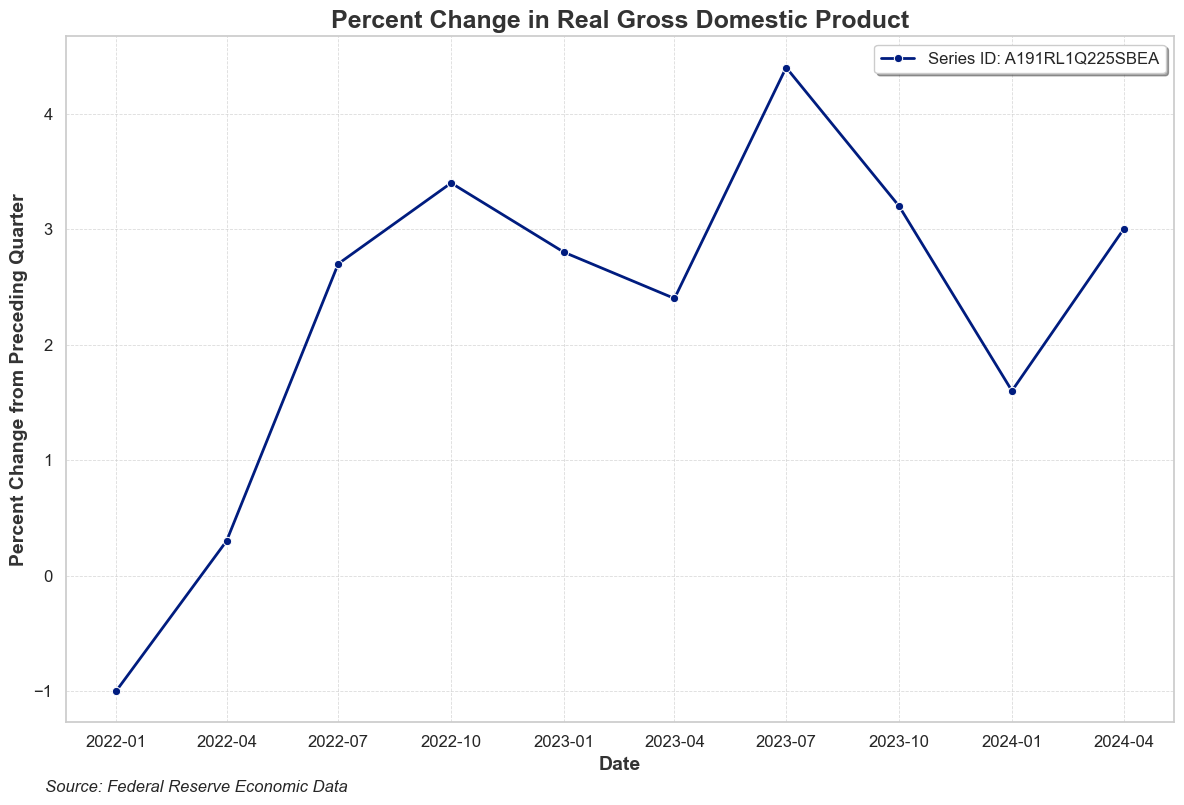

In [16]:
# GDP
# Define the series IDs you want to plot
series_ids = {'A191RL1Q225SBEA': 'FRED'} 

legend = ["Series ID: A191RL1Q225SBEA"]


plot_series(series_ids, 
                 title="Percent Change in Real Gross Domestic Product", 
                 y_label='Percent Change from Preceding Quarter',  # Adjust units as per your data
                 legend_text_generator=legend,
                 from_date='2022-01-01',
                 legend_loc='upper right',
                 )  


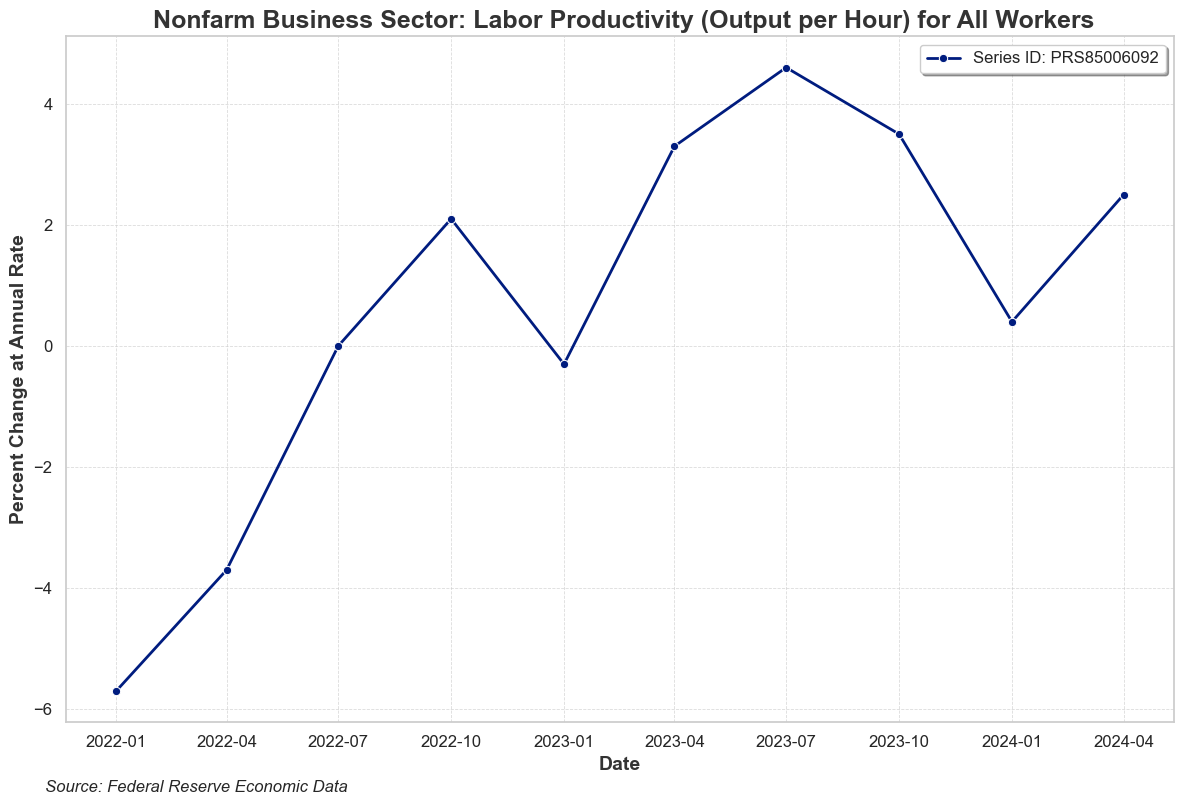

In [17]:
# Labor productivity (output per hour)
# Define the series IDs you want to plot
series_ids = {'PRS85006092': 'FRED'} 

legend = ["Series ID: PRS85006092"]


plot_series(series_ids, 
                 title=" Nonfarm Business Sector: Labor Productivity (Output per Hour) for All Workers", 
                 y_label='Percent Change at Annual Rate',  # Adjust units as per your data
                 legend_text_generator=legend,
                 from_date='2022-01-01',
                 legend_loc='upper right',
                 )  


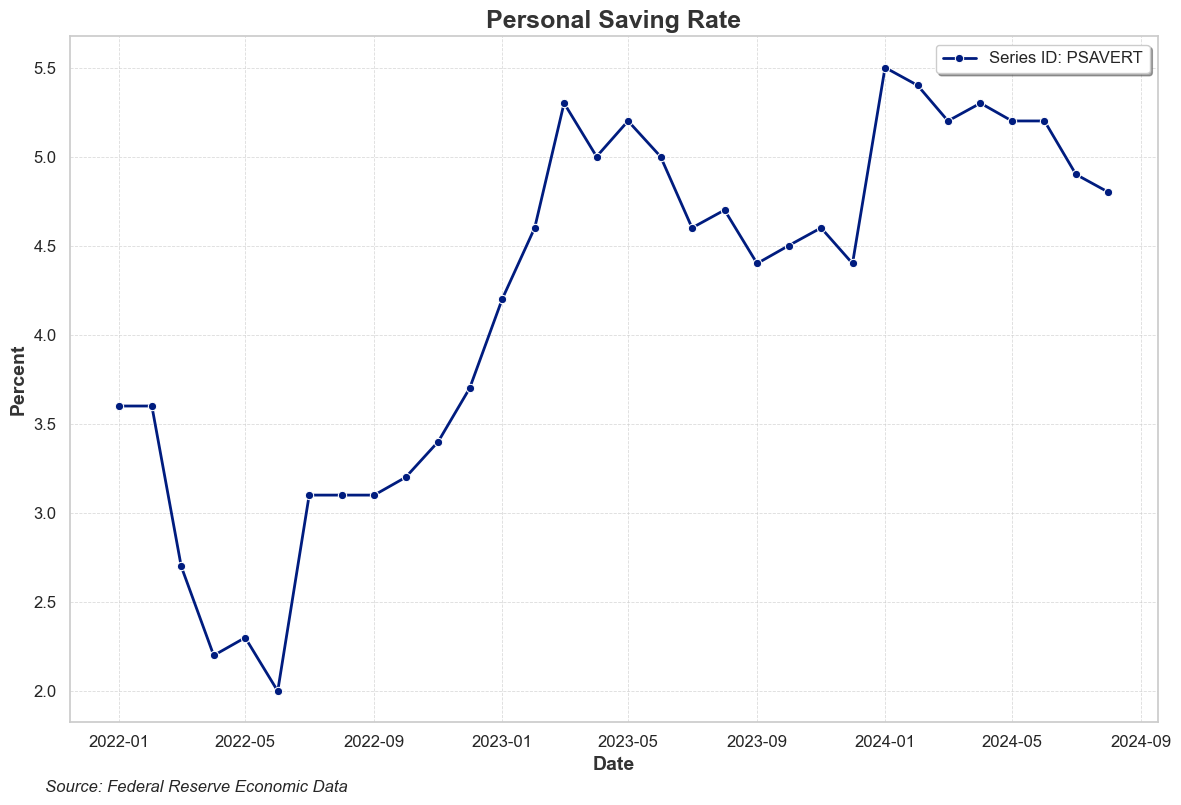

In [18]:
# Saving Rate
# Define the series IDs you want to plot
series_ids = {'PSAVERT': 'FRED'} 

legend = ["Series ID: PSAVERT"]


plot_series(series_ids, 
                 title="Personal Saving Rate", 
                 y_label='Percent',  # Adjust units as per your data
                 legend_text_generator=legend,
                 from_date='2022-01-01',
                 legend_loc='upper right',
                 )  


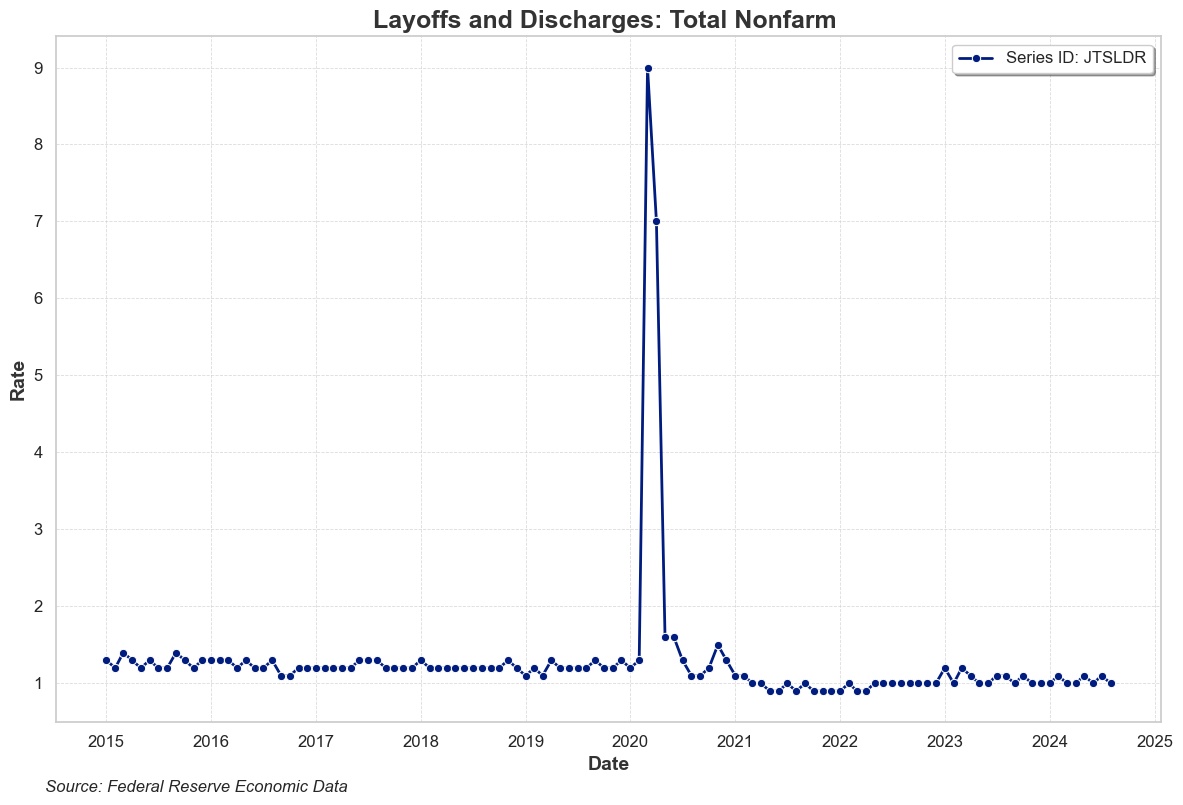

In [19]:
# Layoffs and Discharges: Total Nonfarm
# Define the series IDs you want to plot
series_ids = {'JTSLDR': 'FRED'} 

legend = ["Series ID: JTSLDR"]


plot_series(series_ids, 
                 title="Layoffs and Discharges: Total Nonfarm ", 
                 y_label='Rate',  # Adjust units as per your data
                 legend_text_generator=legend,
                 from_date='2015-01-01',
                 legend_loc='upper right',
                 )  


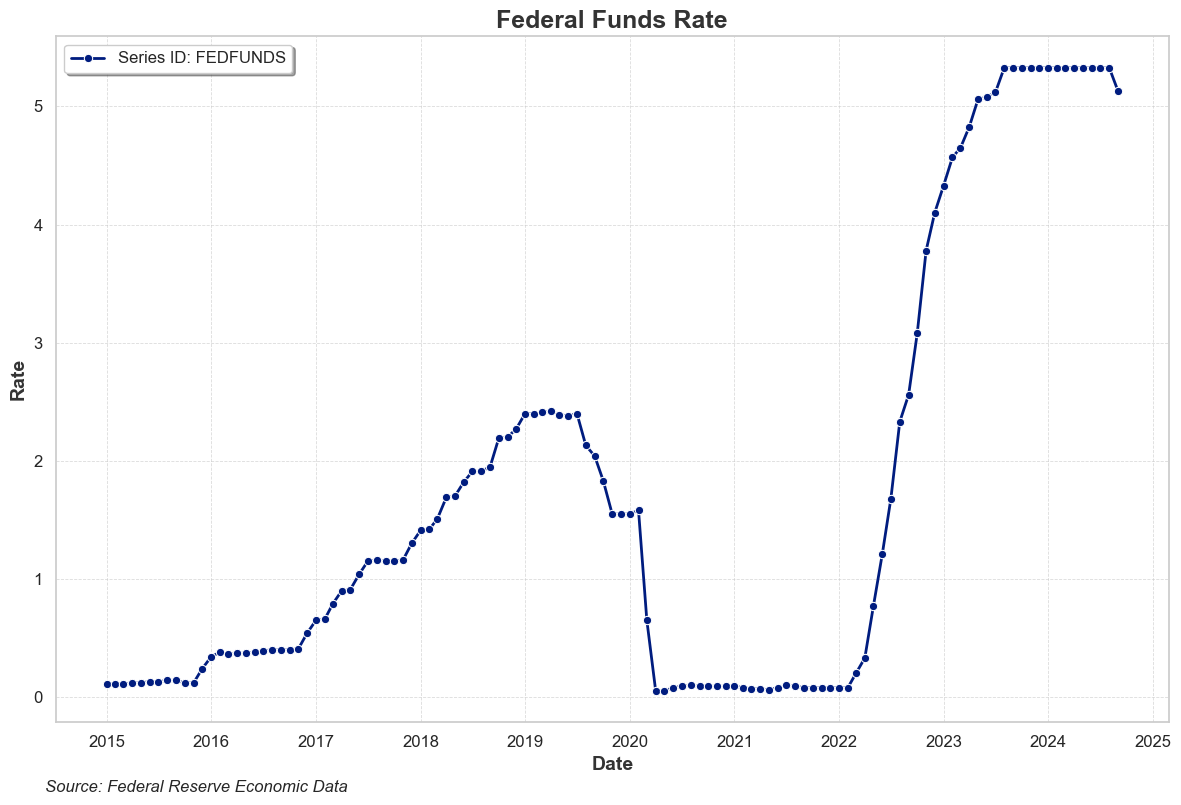

In [20]:
# Layoffs and Discharges: Total Nonfarm
# Define the series IDs you want to plot
series_ids = {'FEDFUNDS': 'FRED'} 

legend = ["Series ID: FEDFUNDS"]


plot_series(series_ids, 
                 title="Federal Funds Rate", 
                 y_label='Rate',  # Adjust units as per your data
                 legend_text_generator=legend,
                 from_date='2015-01-01',
                 legend_loc='upper left',
                 )  


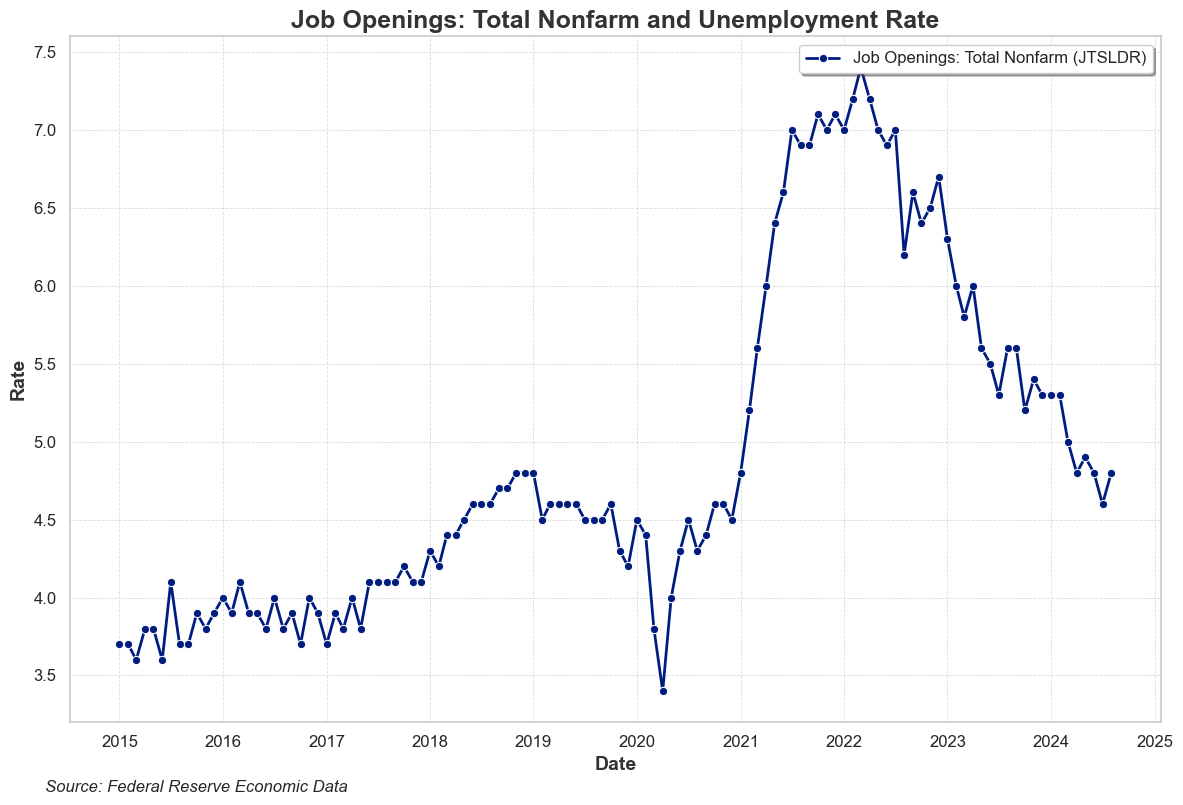

In [21]:
# Job Openings: Total Nonfarm and Unemployment Rate
series_ids = {'JTSJOR': 'FRED', 'UNRATE': 'FRED'} 

legend = ["Job Openings: Total Nonfarm (JTSLDR)", "Unemployment Rate (UNRATE)"]


plot_series(series_ids, 
                 title="Job Openings: Total Nonfarm and Unemployment Rate", 
                 y_label='Rate',  # Adjust units as per your data
                 legend_text_generator=legend,
                 from_date='2015-01-01',
                 legend_loc='upper right',
                 )  


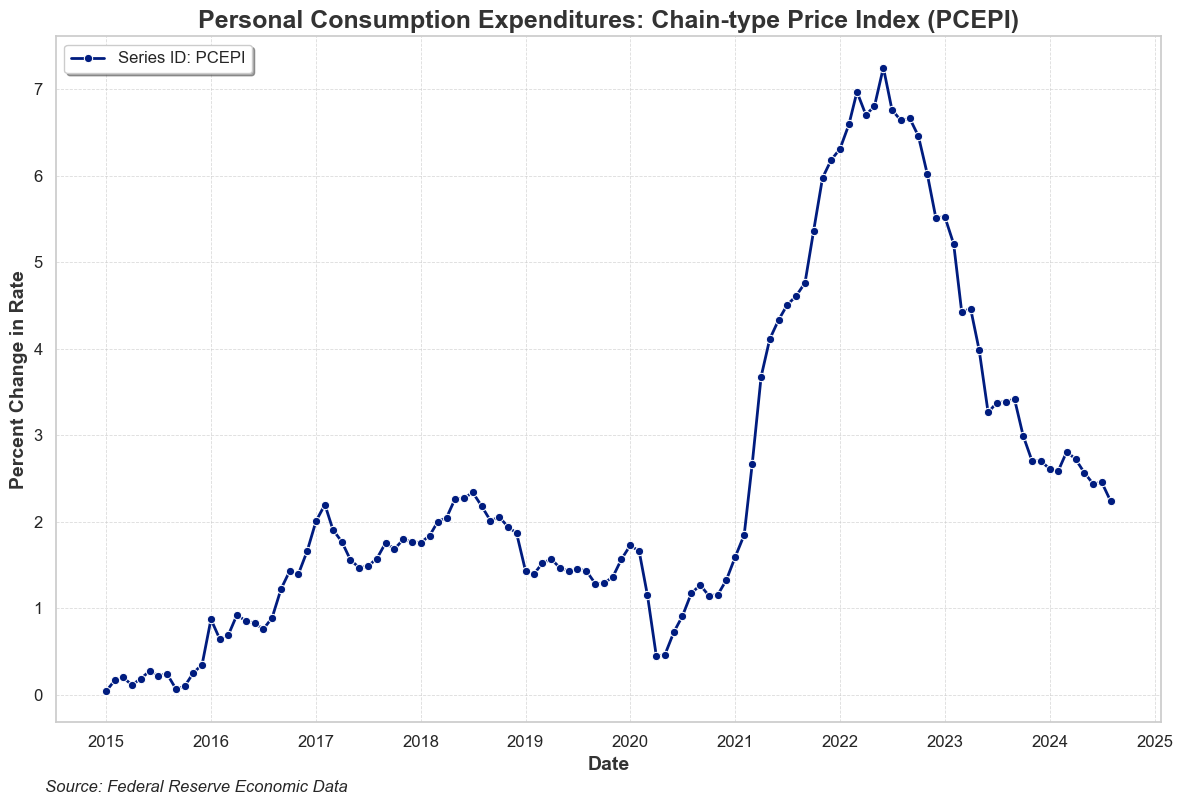

In [22]:
# PCE for All Urban Consumers

# Define the series IDs you want to plot
series_ids = {
    'PCEPI': 'FRED',
}

legend = [
    "Series ID: PCEPI",
]


plot_series(series_ids, 
                 title="Personal Consumption Expenditures: Chain-type Price Index (PCEPI)", 
                 legend_text_generator=legend,
                 y_label='Percent Change in Rate',
                 from_date='2014-01-01',
                 periods_in_year=12,
                 year_over_year=True,
                 legend_loc='upper left')



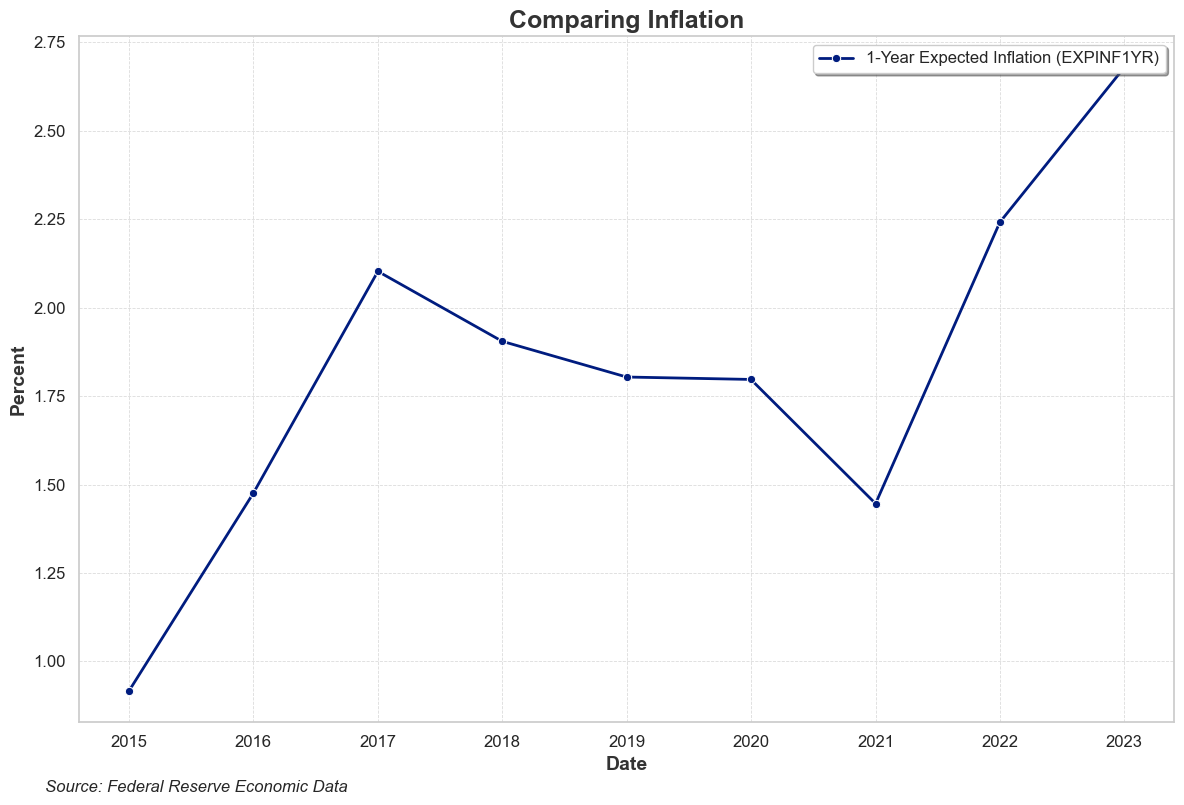

In [23]:
# Job Openings: Total Nonfarm and Unemployment Rate
series_ids = {'EXPINF1YR': 'FRED', 'FPCPITOTLZGUSA': 'FRED'} 

legend = ["1-Year Expected Inflation (EXPINF1YR)", "Inflation, consumer prices for the United States (FPCPITOTLZGUSA)"]


plot_series(series_ids, 
    title="Comparing Inflation", 
    y_label='Percent',  # Adjust units as per your data
    legend_text_generator=legend,
    from_date='2015-01-01',
    legend_loc='upper right',
)  


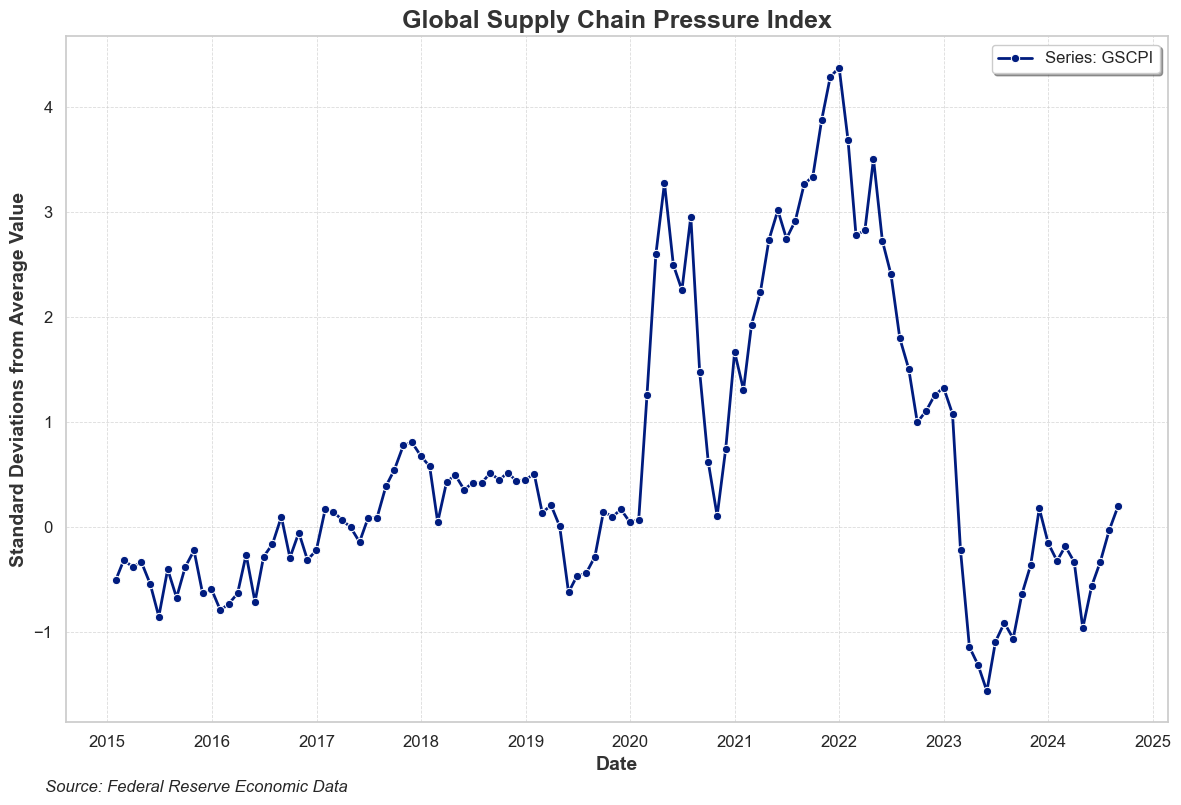

In [24]:
# Job Openings: Total Nonfarm and Unemployment Rate
series_ids = {'data/gscpi.csv': 'FILE'} 

legend = ["Series: GSCPI"]


plot_series(series_ids, 
    title="Global Supply Chain Pressure Index", 
    y_label='Standard Deviations from Average Value',  # Adjust units as per your data
    legend_text_generator=legend,
    from_date='2015-01-01',
    legend_loc='upper right',
)  


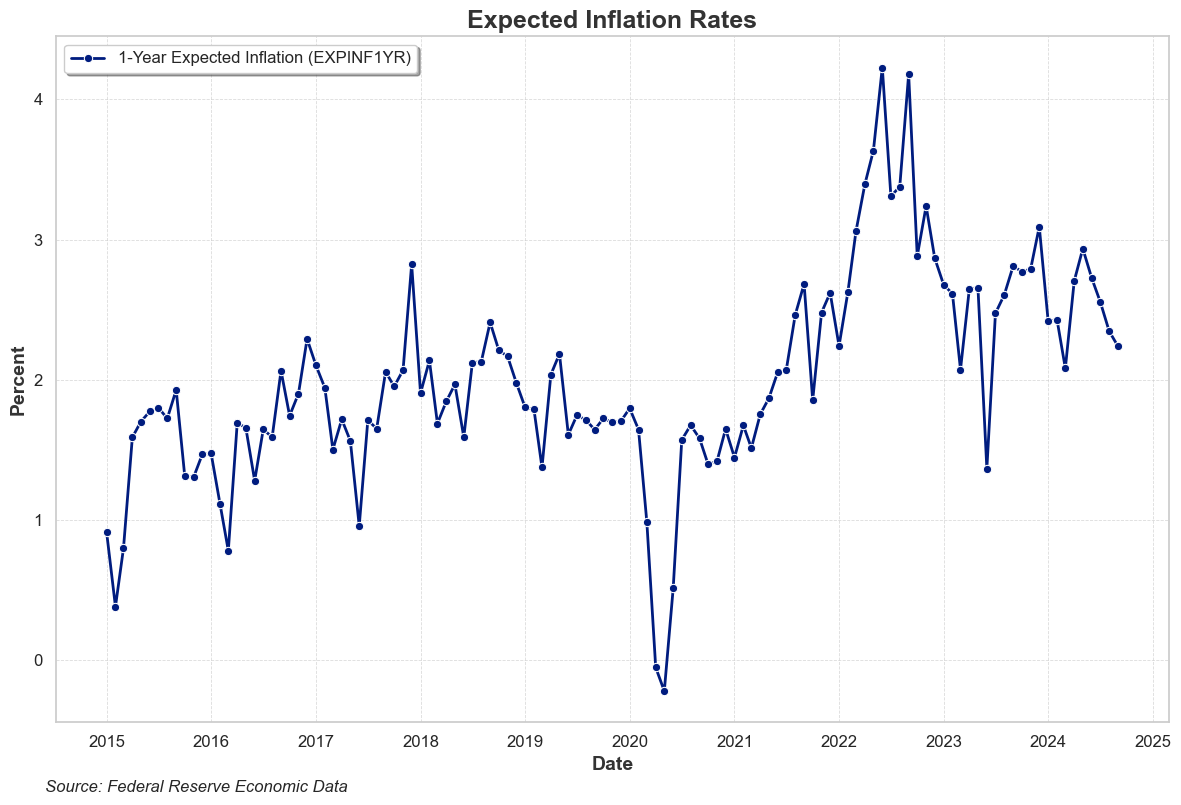

In [25]:
# Compare inflation rates
series_ids = {'EXPINF1YR': 'FRED', 'EXPINF5YR': 'FRED'} 

legend = ["1-Year Expected Inflation (EXPINF1YR)", "5-Year Expected Inflation (EXPINF5YR)", "Series: EXPINF10YR"]

plot_series(series_ids, 
    title="Expected Inflation Rates", 
    y_label='Percent',  # Adjust units as per your data
    legend_text_generator=legend,
    from_date='2015-01-01',
    legend_loc='upper left',
)  


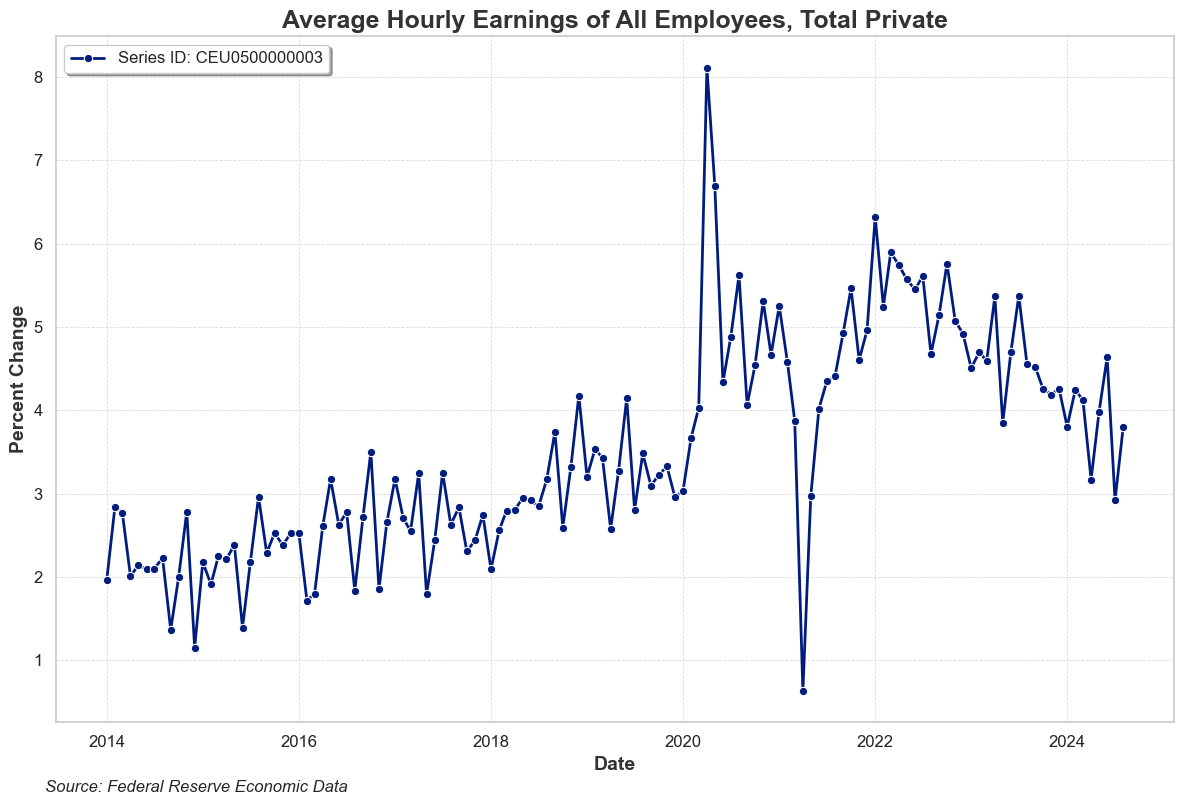

In [26]:
# Average Hourly Earnings of All Employees, Total Private (CEU0500000003)

# Define the series IDs you want to plot
series_ids = {'CEU0500000003': 'FRED',}

legend = ["Series ID: CEU0500000003",]


plot_series(
    series_ids, 
    title="Average Hourly Earnings of All Employees, Total Private", 
    y_label='Percent Change',
    legend_text_generator=legend,
    from_date='2013-01-01',
    legend_loc='upper left',
    year_over_year=True,
    periods_in_year=12,
)


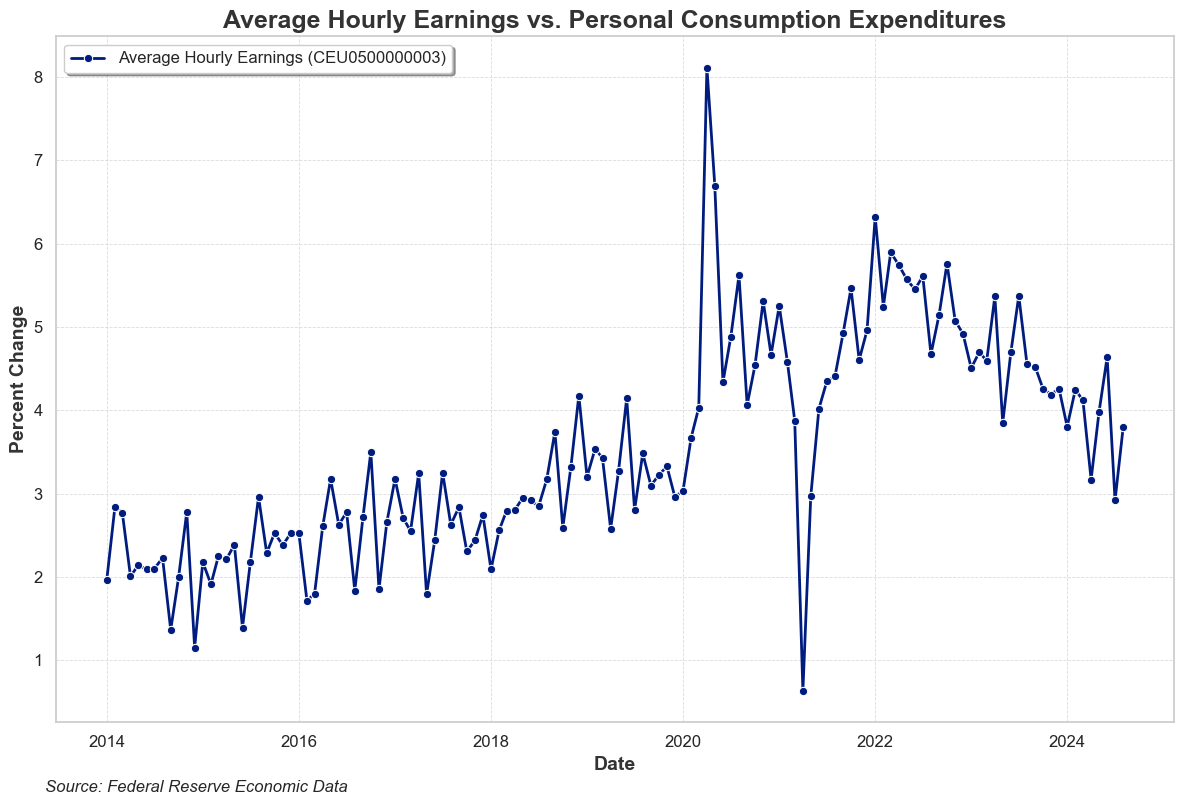

In [27]:
# Average Hourly Earnings of All Employees, Total Private (CEU0500000003)

# Define the series IDs you want to plot
series_ids = {
    'CEU0500000003': 'FRED',
    'PCEPI': 'FRED',
}

legend = ["Average Hourly Earnings (CEU0500000003)", "PCE: Chain Price Index (PCEPI)"]


plot_series(
    series_ids, 
    title="Average Hourly Earnings vs. Personal Consumption Expenditures", 
    y_label='Percent Change',
    legend_text_generator=legend,
    from_date='2013-01-01',
    legend_loc='upper left',
    year_over_year=True,
    periods_in_year=12,
)
